# Normalizing flows: a tutorial


*Table of contents*
1. [Introduction](#Introduction)
2. [Model specification](#Model-specification)
3. [Model compilation](#Model-compilation)
4. [Probabilistic inference](#Probabilistic-inference)
5. [Parameter estimation](#Parameter-estimation)

## Introduction
*Normalizing flows* are parameterized mappings of random variables, which map simple base distributions to more complex distributions.
These mappings are constrained to be invertible and differentiable and can be composed of multiple simpler mappings for improved expressivity.

### Load required packages
Before we can start, we need to import some packages:

In [81]:
using ReactiveMP
using Rocket
using GraphPPL
using Random
using StableRNGs

using LinearAlgebra     # only used for some matrix specifics
using PyPlot            # only used for visualisation
using Distributions     # only used for sampling from multivariate distributions
using Optim             # only used for parameter optimisation

## Model specification

Specifying a flow model is easy. The general recipe looks like follows: `model = FlowModel(input_dim, (layer1(options), layer2(options), ...))`. Here the first argument corresponds to the input dimension of the model and the second argument is a tuple of layers. An example flow model can be defined as 

In [36]:
model = FlowModel(2,
    (
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow(); permute=false)
    )
);

Alternatively, the `input_dim` can also be passed as an `InputLayer` layer as 

In [37]:
model = FlowModel(
    (
        InputLayer(2),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow(); permute=false)
    )
);

In the above `AdditiveCouplingLayer` layers the input ${\bf{x}} = [x_1, x_2, \ldots, x_N]$ is partitioned into chunks of unit length. These partitions are additively coupled to an output ${\bf{y}} = [y_1, y_2, \ldots, y_N]$ as 
$$
\begin{align*}
    y_1 &= x_1 \\
    y_2 &= x_2 + f_1(x_1) \\
    \vdots \\
    y_N &= x_N + f_{N-1}(x_{N-1})
\end{align*}
$$
Importantly, this structure can easily be converted as 
$$
\begin{align*}
    x_1 &= y_1 \\
    x_2 &= y_2 - f_1(x_1) \\
    \vdots \\
    x_N &= y_N - f_{N-1}(x_{N-1})
\end{align*}
$$
$f_n$ is an arbitrarily complex function, here chosen to be a `PlanarFlow`, but this can be interchanged for any function or neural network. The `permute` keyword argument (which defaults to `true`) specifies whether the output of this layer should be randomly permuted or shuffled. This makes sure that the first element is also transformed in consecutive layers.

A permutation layer can also be added by itself as a `PermutationLayer` layer with a custom permutation matrix if desired.

In [38]:
model = FlowModel(
    (
        InputLayer(2),
        AdditiveCouplingLayer(PlanarFlow(); permute=false),
        PermutationLayer(PermutationMatrix(2)),
        AdditiveCouplingLayer(PlanarFlow(); permute=false)
    )
);

## Model compilation
In the current models, the layers are setup to work with the passed input dimension. This means that the function $f_n$ is repeated `input_dim-1` times for each of the partitions. Furthermore the permutation layers are set up with proper permutation matrices. If we print the model we get

In [39]:
model

FlowModel{3, Tuple{ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}, PermutationLayer{Int64}, ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}}}(2, (ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}(2, (ReactiveMP.PlanarFlowEmpty{1}(),), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), ReactiveMP.AdditiveCouplingLayerEmpty{Tuple{ReactiveMP.PlanarFlowEmpty{1}}}(2, (ReactiveMP.PlanarFlowEmpty{1}(),), 1)))

The text below describes the terms above. Please note the distinction in typing and elements, i.e. `FlowModel{types}(elements)`:
- `FlowModel` - specifies that we are dealing with a flow model.
- `3` - Number of layers.
- `Tuple{AdditiveCouplingLayerEmpty{...},PermutationLayer{Int64},AdditiveCouplingLayerEmpty{...}}` - tuple of layer types.
- `Tuple{ReactiveMP.PlanarFlowEmpty{1},ReactiveMP.PlanarFlowEmpty{1}}` - tuple of functions $f_n$.
- `PermutationLayer{Int64}(2, [0 1; 1 0])` - permutation layer with input dimension 2 and permutation matrix `[0 1; 1 0]`.

From inspection we can see that the `AdditiveCouplingLayerEmpty` and `PlanarFlowEmpty` objects are different than before. They are initialized for the correct dimension, but they do not have any parameters registered to them. This is by design to allow for separating the model specification from potential optimization procedures. Before we perform inference in this model, the parameters should be initialized. We can randomly initialize the parameters as

In [9]:
compiled_model = compile(model)

CompiledFlowModel{3, Tuple{AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}, PermutationLayer{Int64}, AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}}}(2, (AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}(2, (PlanarFlow{Float64, Float64}(2.1562688617827903, -0.6838169486519404, 0.8382378681933877),), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}(2, (PlanarFlow{Float64, Float64}(0.6894737823630793, 0.2869753731369175, 0.8361168793753597),), 1)))

Now we can see that random parameters have been assigned to the individual functions inside of our model. Alternatively if we would like to pass our own parameters, then this is also possible. You can easily find the required number of parameters using the `nr_params(model)` function.

In [10]:
compiled_model = compile(model, randn(StableRNG(321), nr_params(model)))

CompiledFlowModel{3, Tuple{AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}, PermutationLayer{Int64}, AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}}}(2, (AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}(2, (PlanarFlow{Float64, Float64}(0.7296412319250487, -0.9767336128037319, -0.4749869451771002),), 1), PermutationLayer{Int64}(2, [0 1; 1 0]), AdditiveCouplingLayer{Tuple{PlanarFlow{Float64, Float64}}}(2, (PlanarFlow{Float64, Float64}(0.3490911082645933, -0.8184067956921087, -1.4578214732352386),), 1)))

## Probabilistic inference

We can perform inference in our compiled model through standard usage of ReactiveMP. Let's first generate some random 2D data which has been sampled from a standard normal distribution and is consecutively passed through a normalizing flow. Using the `forward(model, data)` function we can propagate data in the forward direction through the flow.

In [11]:
function generate_data(nr_samples::Int64, model::CompiledFlowModel; seed = 123)

    rng = StableRNG(seed)
    
    # specify latent sampling distribution
    dist = MvNormal([1.5, 0.5], I)

    # sample from the latent distribution
    x = rand(rng, dist, nr_samples)

    # transform data
    y = zeros(Float64, size(x))
    for k = 1:nr_samples
        y[:,k] .= ReactiveMP.forward(model, x[:,k])
    end

    # return data
    return y, x

end;

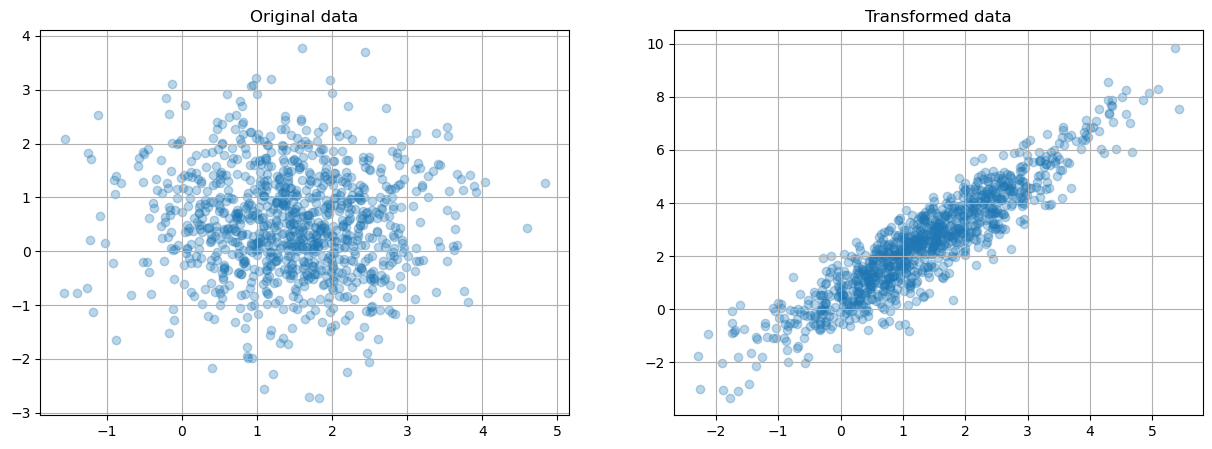

In [85]:
# generate data
y_gen, x_gen = generate_data(1000, compiled_model)

# plot generated data
_, ax = plt.subplots(ncols=2, figsize=(15,5))
ax[1].scatter(x_gen[1,:], x_gen[2,:], alpha=0.3)
ax[2].scatter(y_gen[1,:], y_gen[2,:], alpha=0.3)
ax[1].set_title("Original data")
ax[2].set_title("Transformed data")
ax[1].grid(), ax[2].grid();

The probabilistic model for doing inference can be described as 

In [86]:
@model function normalizing_flow(nr_samples::Int64)
    
    # initialize variables
    z_μ   = randomvar()
    z_Λ   = randomvar()
    x     = randomvar(nr_samples)
    y_lat = randomvar(nr_samples)
    y     = datavar(Vector{Float64}, nr_samples)

    # specify prior
    z_μ ~ MvNormalMeanCovariance(zeros(2), huge*diagm(ones(2)))
    z_Λ ~ Wishart(2.0, tiny*diagm(ones(2)))

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x[k] ~ MvNormalMeanPrecision(z_μ, z_Λ)

        # specify transformed latent value
        y_lat[k] ~ Flow(x[k])

        # specify observations
        y[k] ~ MvNormalMeanCovariance(y_lat[k], tiny*diagm(ones(2)))

    end

    # return variables
    return z_μ, z_Λ, x, y_lat, y

end;

Here the flow model is passed inside a meta data object of the flow node.
Inference then resorts to

In [87]:
observations = [y[:,k] for k=1:size(y,2)]

fmodel         = Model(normalizing_flow, length(observations))
data          = (y = observations, )
initmarginals = (z_μ = MvNormalMeanCovariance(zeros(2), huge*diagm(ones(2))), z_Λ = Wishart(2.0, tiny*diagm(ones(2))))
returnvars    = (z_μ = KeepLast(), z_Λ = KeepLast(), x = KeepLast(), y_lat = KeepLast())

constraints = @constraints begin
    q(z_μ, x, z_Λ) = q(z_μ)q(z_Λ)q(x)
end

@meta function fmeta(model)
    compiled_model = compile(model, randn(StableRNG(321), nr_params(model)))
    Flow(y_lat, x) -> FlowMeta(compiled_model)
end

# First execution is slow due to Julia's initial compilation 
result = inference(
    model = fmodel, 
    data  = data,
    constraints   = constraints,
    meta          = fmeta(model),
    initmarginals = initmarginals,
    returnvars    = returnvars,
    free_energy   = true,
    iterations    = 10, 
    showprogress  = false
);

In [88]:
using Parameters
@unpack z_μ, z_Λ, x, y_lat = result.posteriors
fe_flow = result.free_energy

zμ_flow, zΛ_flow, x_flow, y_flow = z_μ, z_Λ, x, y_lat;

As we can see, the variational free energy decreases inside of our model.

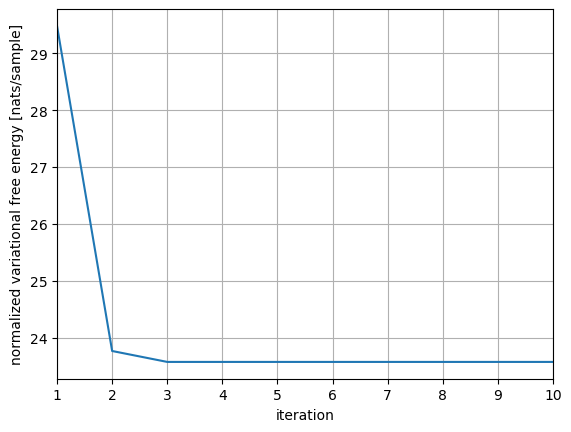

In [89]:
plt.figure()
plt.plot(1:10, fe_flow/size(y,2))
plt.grid()
plt.xlim(1,10)
plt.xlabel("iteration")
plt.ylabel("normalized variational free energy [nats/sample]");

If we plot a random noisy observation and its approximated transformed uncertainty we obtain:

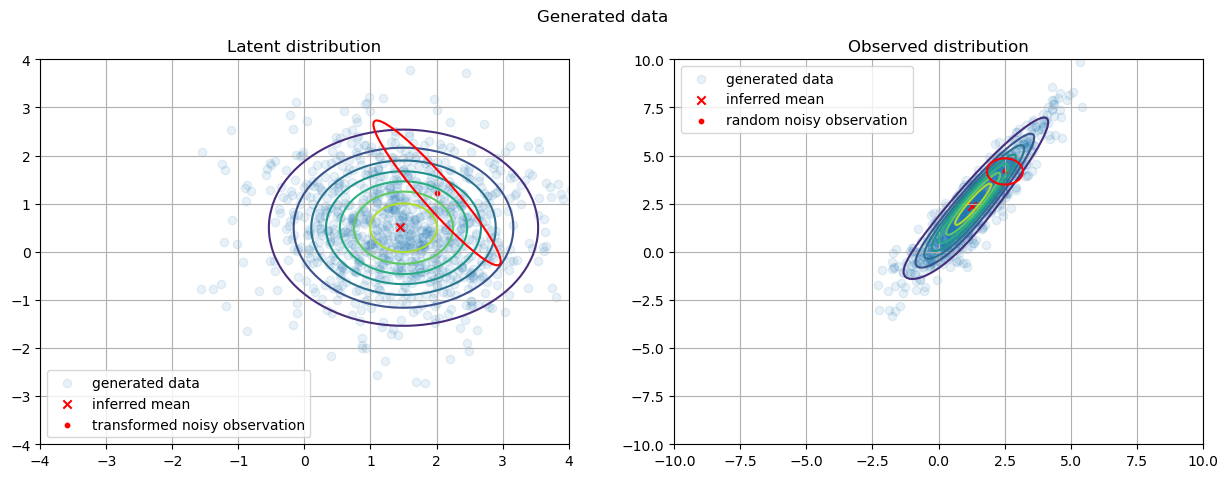

In [98]:
# pick a random observation
id = rand(StableRNG(321), 1:size(y,2))
rand_observation = MvNormal(y[:,id], 5e-1*diagm(ones(2)))
warped_observation = MvNormal(ReactiveMP.backward(compiled_model, y[:,id]), ReactiveMP.inv_jacobian(compiled_model, y[:,id])*5e-1*diagm(ones(2))*ReactiveMP.inv_jacobian(compiled_model, y[:,id])');

# plot inferred means and transformed point
fig, ax = plt.subplots(ncols = 2, figsize=(15,5))
ax[1].scatter(x_gen[1,:], x_gen[2,:], alpha=0.1, label="generated data")
ax[1].contour(repeat(-5:0.1:5, 1, 101), repeat(-5:0.1:5, 1, 101)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), [x...]), collect(Iterators.product(-5:0.1:5, -5:0.1:5))), label="true distribution")
ax[1].scatter(mean(zμ_flow)[1], mean(zμ_flow)[2], color="red", marker="x", label="inferred mean")
ax[1].contour(repeat(-10:0.01:10, 1, 2001), repeat(-10:0.01:10, 1, 2001)', map( (x) -> pdf(warped_observation, [x...]), collect(Iterators.product(-10:0.01:10, -10:0.01:10))), colors="red", levels=1)
ax[1].scatter(mean(warped_observation)..., color="red", s=10, label="transformed noisy observation")
ax[2].scatter(y_gen[1,:], y_gen[2,:], alpha=0.1, label="generated data")
ax[2].scatter(ReactiveMP.forward(compiled_model, mean(zμ_flow))..., color="red", marker="x", label="inferred mean")
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(MvNormal([1.5, 0.5], I), ReactiveMP.backward(compiled_model, [x...])), collect(Iterators.product(-10:0.1:10, -10:0.1:10))))
ax[2].contour(repeat(-10:0.1:10, 1, 201), repeat(-10:0.1:10, 1, 201)', map( (x) -> pdf(rand_observation, [x...]), collect(Iterators.product(-10:0.1:10, -10:0.1:10))), colors="red", levels=1, label="random noisy observation")
ax[2].scatter(mean(rand_observation)..., color="red", s=10, label="random noisy observation")
ax[1].grid(), ax[2].grid()
ax[1].set_xlim(-4,4), ax[1].set_ylim(-4,4), ax[2].set_xlim(-10,10), ax[2].set_ylim(-10,10)
ax[1].legend(), ax[2].legend()
fig.suptitle("Generated data")
ax[1].set_title("Latent distribution"), ax[2].set_title("Observed distribution");

## Parameter estimation

The flow model is often used to learn unknown probabilistic mappings. Here we will demonstrate it as follows for a binary classification task with the following data:

In [108]:
function generate_data(nr_samples::Int64; seed = 123)
    
    rng = StableRNG(seed)

    # sample weights
    w = rand(rng, nr_samples, 2)

    # sample appraisal
    y = zeros(Float64, nr_samples)
    for k = 1:nr_samples
        y[k] = 1.0*(w[k,1] > 0.5)*(w[k,2] < 0.5)
    end

    # return data
    return y, w

end;

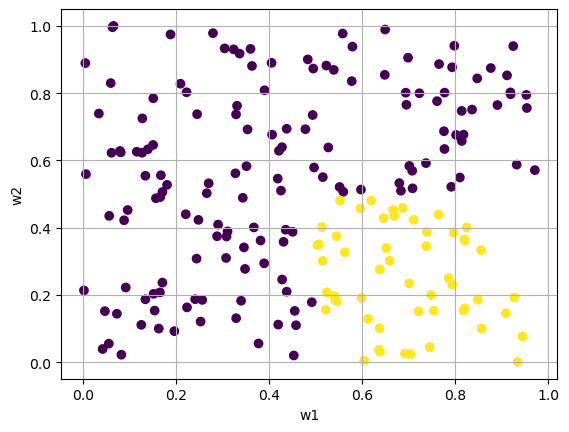

In [109]:
data_y, data_x = generate_data(200);
plt.figure()
plt.scatter(data_x[:,1], data_x[:,2], c=data_y)
plt.grid()
plt.xlabel("w1")
plt.ylabel("w2");

We will then specify a possible flow model as

In [101]:
# specify flow model
model = FlowModel(2,
    (
        AdditiveCouplingLayer(PlanarFlow()), # defaults to AdditiveCouplingLayer(PlanarFlow(); permute=true)
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow()),
        AdditiveCouplingLayer(PlanarFlow(); permute=false)
    )
);

The corresponding probabilistic model for the binary classification task can be created as

In [119]:
@model [default_factorisation=FullFactorisation()] function flow_classifier(nr_samples::Int64)
    
    # initialize variables
    x_lat  = randomvar(nr_samples)
    y_lat1 = randomvar(nr_samples)
    y_lat2 = randomvar(nr_samples)
    y      = datavar(Float64, nr_samples)
    x      = datavar(Vector{Float64}, nr_samples)

    # specify observations
    for k = 1:nr_samples

        # specify latent state
        x_lat[k] ~ MvNormalMeanPrecision(x[k], 1e3*diagm(ones(2)))

        # specify transformed latent value
        y_lat1[k] ~ Flow(x_lat[k])
        y_lat2[k] ~ dot(y_lat1[k], [1, 1])

        # specify observations
        y[k] ~ Probit(y_lat2[k]) # default: where { pipeline = RequireInbound(in = NormalMeanPrecision(0, 1.0)) }

    end

    # return variables
    return x_lat, x, y_lat1, y_lat2, y

end;

In [126]:
fcmodel       = Model(flow_classifier, length(data_y))
data          = (y = data_y, x = [data_x[k,:] for k=1:size(data_x,1)], )
# returnvars    = (y_lat1 = KeepLast(), x_lat = KeepLast())

@meta function fmeta(model, params)
    compiled_model = compile(model, params)
    Flow(y_lat1, x_lat) -> FlowMeta(compiled_model)
end

Here we see that the compilation occurs inside of our probabilistic model. As a result we can pass parameters (and a model) to this function which we wish to opmize for some criterium, such as the variational free energy. Inference can be described as

For the optimization procedure, we will simplify our inference loop, such that it only accepts parameters as an argument (which is wishes to optimize) and outputs a performance metric.

In [133]:
function f(params)
    result = inference(
        model         = fcmodel, 
        data          = data,
        meta          = fmeta(model, params),
        free_energy   = true,
        iterations    = 10, 
        showprogress  = false
    );
    
    result.free_energy[end]
end;

Optimization can be performed using the `Optim` package. Alternatively, other (custom) optimizers can be implemented, such as:

```julia
res = optimize(f, randn(nr_params(model)), LBFGS(), Optim.Options(g_tol = 1e-3, iterations = 100, store_trace = true, show_trace = true))
``` 

- uses finitediff and is slower/less accurate.

*or*

```julia
# create gradient function
g = (x) -> ForwardDiff.gradient(f, x);

# specify initial params
params = randn(nr_params(model))

# create custom optimizer (here Adam)
optimizer = Adam(params; λ=1e-1)

# allocate space for gradient
∇ = zeros(nr_params(model))

# perform optimization
for it = 1:10000

    # backward pass
    ∇ .= ForwardDiff.gradient(f, optimizer.x)

    # gradient update
    ReactiveMP.update!(optimizer, ∇)

end

```

In [144]:
res = optimize(f, randn(StableRNG(42), nr_params(model)), LBFGS(), Optim.Options(store_trace = true, show_trace = true, show_every = 10), autodiff=:forward)

Iter     Function value   Gradient norm 
     0     2.672600e+03     3.675482e+03
 * time: 0.0001480579376220703
    10     7.378704e+01     2.669554e+01
 * time: 6.7671239376068115
    20     6.575501e+01     3.103408e+01
 * time: 11.697844982147217
    30     6.549138e+01     1.486239e+01
 * time: 17.462985038757324
    40     6.466059e+01     1.150685e+02
 * time: 22.61334204673767
    50     5.899921e+01     2.009424e+02
 * time: 28.156471967697144
    60     5.199048e+01     4.392421e+01
 * time: 36.18769884109497
    70     4.362553e+01     6.461798e+01
 * time: 53.67331600189209
    80     3.849833e+01     5.409339e+02
 * time: 69.68458700180054
    90     3.775961e+01     7.723758e+00
 * time: 75.17620086669922
   100     3.699763e+01     3.728975e+01
 * time: 81.18430399894714
   110     3.665566e+01     1.716740e+01
 * time: 86.81751704216003
   120     3.537315e+01     7.619218e+01
 * time: 94.12834000587463
   130     3.465673e+01     5.290885e+01
 * time: 118.7558519840240

 * Status: success

 * Candidate solution
    Final objective value:     3.443402e+01

 * Found with
    Algorithm:     L-BFGS

 * Convergence measures
    |x - x'|               = 0.00e+00 ≤ 0.0e+00
    |x - x'|/|x'|          = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|         = 0.00e+00 ≤ 0.0e+00
    |f(x) - f(x')|/|f(x')| = 0.00e+00 ≤ 0.0e+00
    |g(x)|                 = 1.25e+02 ≰ 1.0e-08

 * Work counters
    Seconds run:   249  (vs limit Inf)
    Iterations:    145
    f(x) calls:    1205
    ∇f(x) calls:   1205


optimization results are then given as

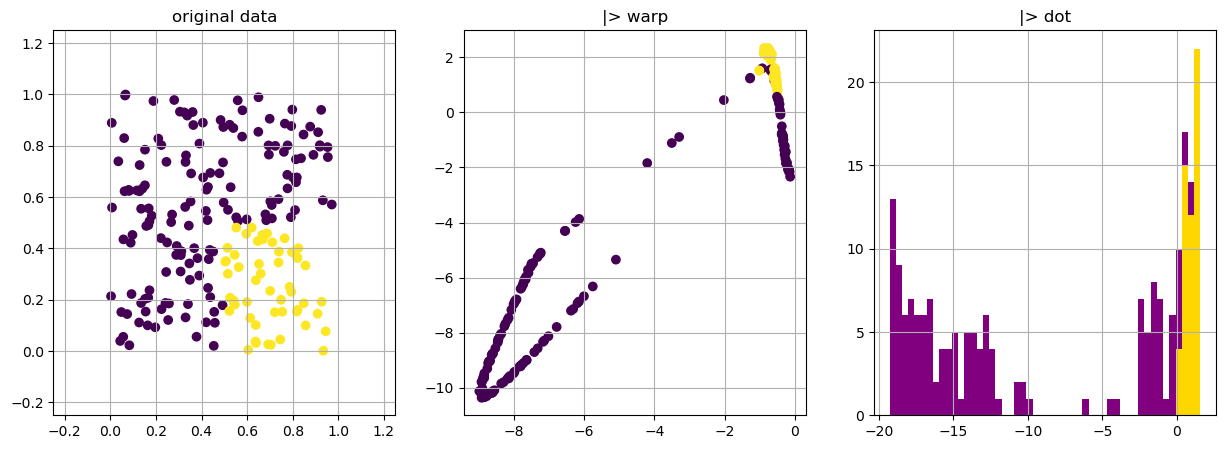

In [145]:
params = Optim.minimizer(res)
inferred_model = compile(model, params)
trans_data_x_1 = hcat(map((x) -> ReactiveMP.forward(inferred_model, x), [data_x[k,:] for k=1:size(data_x,1)])...)'
trans_data_x_2 = map((x) -> dot([1, 1], x), [trans_data_x_1[k,:] for k=1:size(data_x,1)])
trans_data_x_2_split = [trans_data_x_2[data_y .== 1.0], trans_data_x_2[data_y .== 0.0]]
fig, ax = plt.subplots(ncols = 3, figsize=(15,5))
ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
ax[2].scatter(trans_data_x_1[:,1], trans_data_x_1[:,2], c = data_y)
ax[3].hist(trans_data_x_2_split; stacked=true, bins=50, color = ["gold", "purple"])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlim(-0.25,1.25), ax[1].set_ylim(-0.25,1.25)
ax[1].set_title("original data"), ax[2].set_title("|> warp"), ax[3].set_title("|> dot");

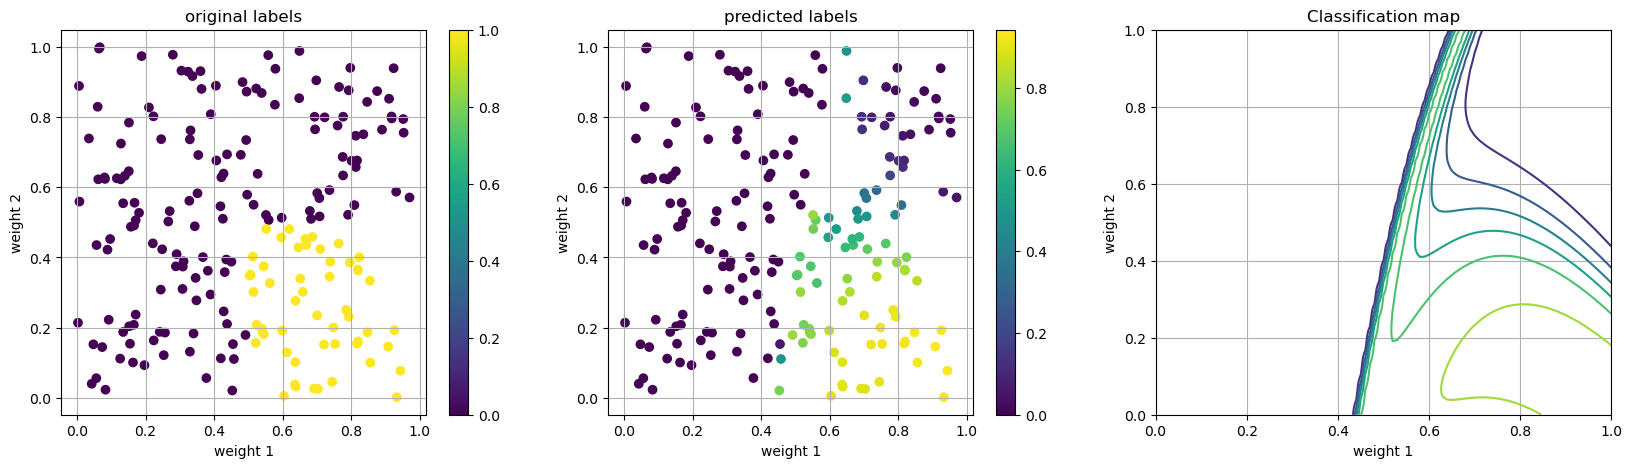

In [146]:
using StatsFuns: normcdf
classification_map = map((x) -> normcdf(dot([1,1],x)), map((x) -> ReactiveMP.forward(inferred_model, [x...]), collect(Iterators.product(0:0.01:1, 0:0.01:1))))
fig, ax = plt.subplots(ncols = 3, figsize=(20,5))
im1 = ax[1].scatter(data_x[:,1], data_x[:,2], c = data_y)
im2 = ax[2].scatter(data_x[:,1], data_x[:,2], c = normcdf.(trans_data_x_2))
ax[3].contour(repeat(0:0.01:1, 1, 101), repeat(0:0.01:1, 1, 101)', classification_map)
plt.colorbar(im1, ax=ax[1])
plt.colorbar(im2, ax=ax[2])
ax[1].grid(), ax[2].grid(), ax[3].grid()
ax[1].set_xlabel("weight 1"), ax[1].set_ylabel("weight 2"), ax[2].set_xlabel("weight 1"), ax[2].set_ylabel("weight 2"), ax[3].set_xlabel("weight 1"), ax[3].set_ylabel("weight 2")
ax[1].set_title("original labels"), ax[2].set_title("predicted labels"), ax[3].set_title("Classification map");